In [22]:
import sys, os
import importlib
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [ ]:
SRC_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PARENT_DIR)
conf = importlib.import_module('confs.iiwa_conf')
env = getattr(conf, 'IiwaEnv')(conf)


from neural_network import ActorCriticNet
from rl_trainer import RLTrainer
from opt.traj_opt import TrajOpt

ac_net = ActorCriticNet(env, conf)
actor = ac_net.create_actor()
critic = ac_net.create_critic()
TO = TrajOpt(env, conf)

# Load the weights
actor_path = '/home/seyoungree/Documents/GATO-RL/iiwa/2025-07-25_13-35/actor_final.pth'
critic_path = '/home/seyoungree/Documents/GATO-RL/iiwa/2025-07-25_13-35/critic_final.pth'
actor.load_state_dict(torch.load(actor_path, map_location='cpu'))
critic.load_state_dict(torch.load(critic_path, map_location='cpu'))
actor.eval()
critic.eval()

Sequential(
  (0): Linear(in_features=15, out_features=64, bias=True)
  (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (2): Mish()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (5): Mish()
  (6): Linear(in_features=64, out_features=128, bias=True)
  (7): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (8): Mish()
  (9): Linear(in_features=128, out_features=128, bias=True)
  (10): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (11): Mish()
  (12): Linear(in_features=128, out_features=1, bias=True)
)

In [24]:
%matplotlib inline

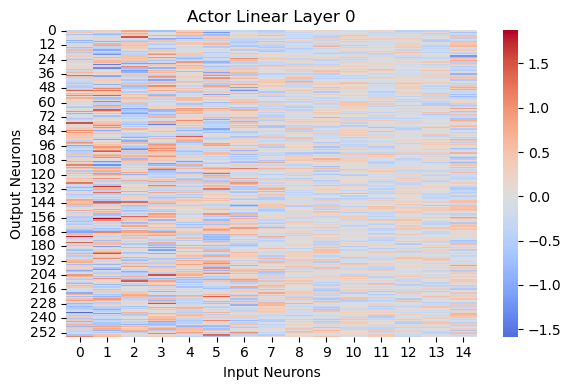

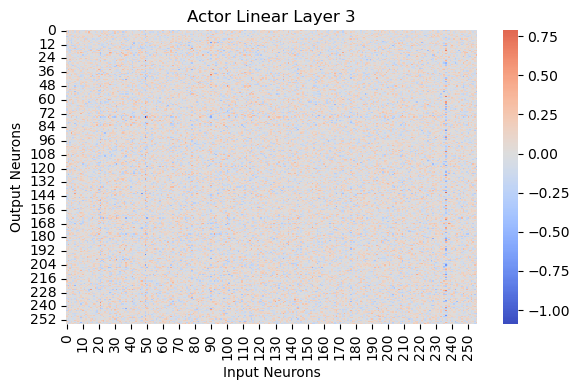

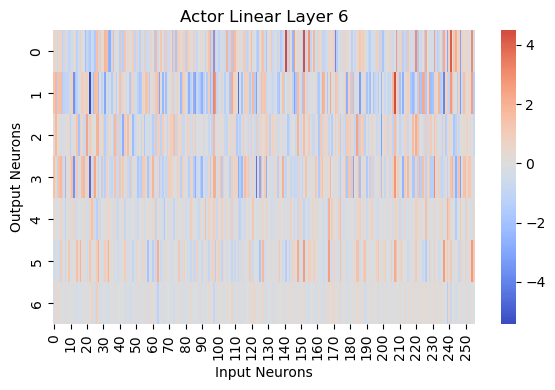

In [25]:
def visualize_weights(weights, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(weights, cmap='coolwarm', center=0)
    plt.title(title)
    plt.xlabel("Input Neurons")
    plt.ylabel("Output Neurons")
    plt.tight_layout()
    plt.show()

def visualize_model_weights(model, name="Model"):
    for i, layer in enumerate(model):
        # Standard linear layer
        if isinstance(layer, nn.Linear):
            w = layer.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Linear Layer {i}")
        
        elif hasattr(layer, "linear") and isinstance(layer.linear, nn.Linear):
            w = layer.linear.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Siren Layer {i}")
# Visualize
visualize_model_weights(actor, "Actor")

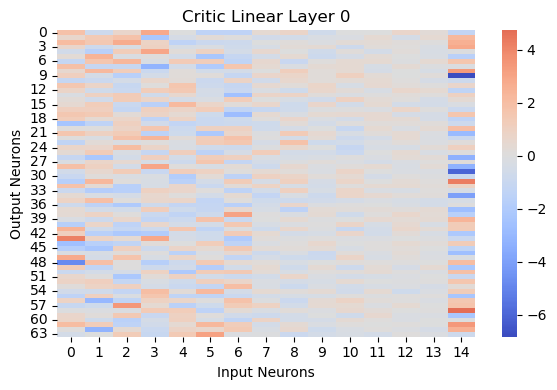

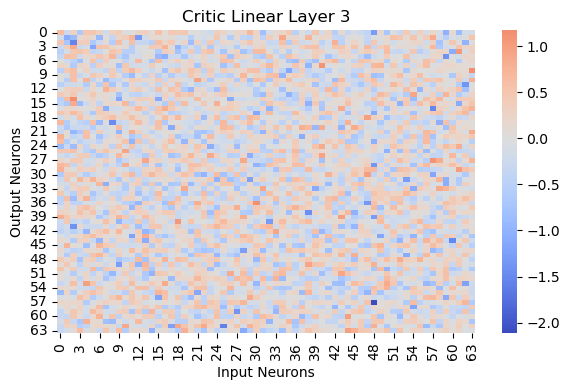

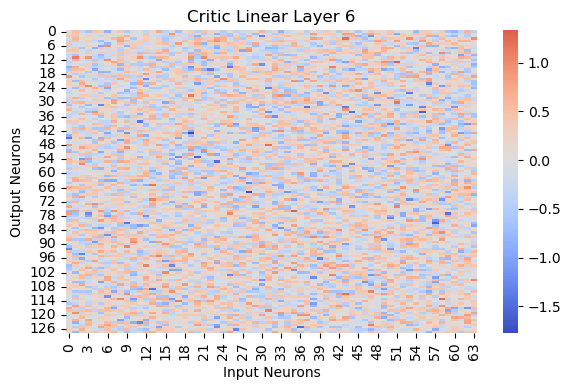

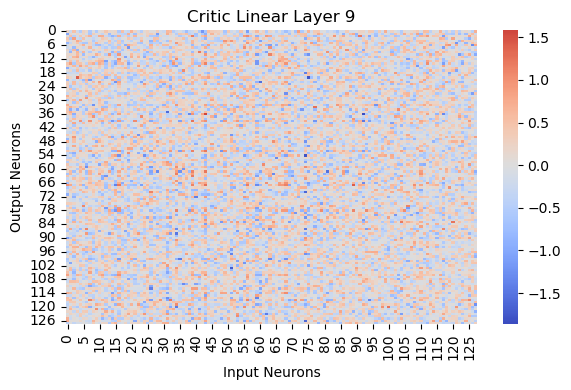

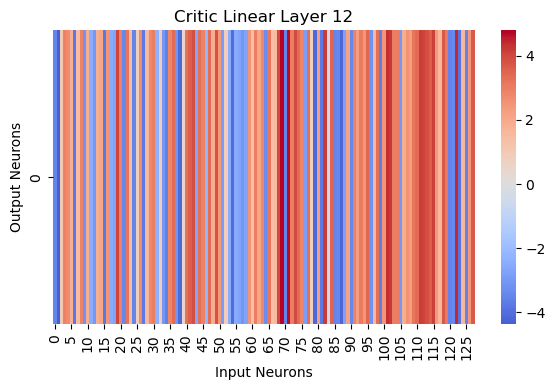

In [26]:
visualize_model_weights(critic, "Critic")

   t |       q0 |       q1 |       q2 |       q3 |       q4 |       q5 |       q6 |       v0 |       v1 |       v2 |       v3 |       v4 |       v5 |       v6 | u 0 | u 1 | u 2 | u 3 | u 4 | u 5 | u 6
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   0 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |    0.000 |  -10.820 |  -77.811 |  -10.455 |   32.553 |   -3.529 |   -2.427 |   -1.308
   1 |   -0.000 |   -0.000 |   -0.017 |    0.003 |    0.004 |   -0.000 |   -0.012 |   -0.048 |   -0.005 |   -1.749 |    0.325 |    0.356 |   -0.037 |   -1.174 |   12.424 |  -86.729 |    9.626 |   19.758 |    1.581 |   -1.540 |    1.207
   2 |    0.003 |   -0.005 |   -0.014 |   -0.003 |   -0.006 |   -0.009 |   -0.011 |    0.322 |   -0.509 |    0.350 |   -0.587 

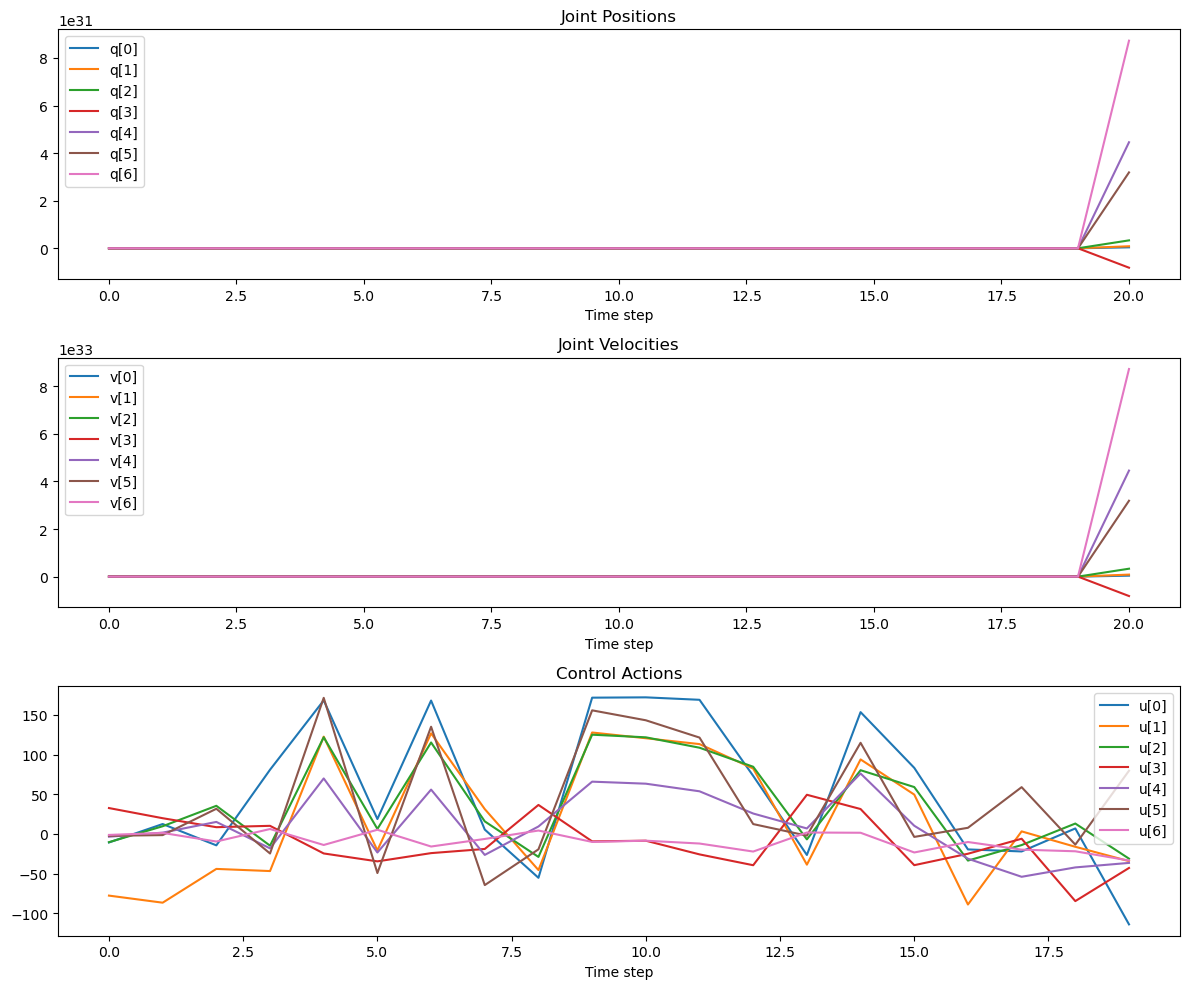

In [27]:
# Test the actor with a single trajectory rollout from an initial state for IIWA
T = 0.0
steps = conf.NSTEPS - int(T / conf.dt)

# Initialize state: 7 joint positions + 7 joint velocities + time
init_q = np.zeros(7)
init_v = np.zeros(7)
init_state = np.concatenate([init_q, init_v, [T]])

states = np.zeros((steps + 1, conf.nx + 1))
states[0] = init_state
actions = np.zeros((steps, conf.nu))

# Header
joint_labels = [f"q{i}" for i in range(7)] + [f"v{i}" for i in range(7)]
header = f"{'t':>4} | " + " | ".join([f"{l:>8}" for l in joint_labels]) + " | " + " | ".join([f"u{i:>2}" for i in range(7)])
print(header)
print("-" * len(header))

# Rollout
for t in range(steps):
    state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
    with torch.no_grad():
        action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
    actions[t] = action
    q_vals = states[t, :7]
    v_vals = states[t, 7:14]
    line = f"{t:4d} | " + " | ".join(f"{x:8.3f}" for x in np.concatenate([q_vals, v_vals, action]))
    print(line)
    states[t + 1, :] = env.simulate(states[t, :-1], actions[t])

# Plot all joints
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Plot joint positions
for i in range(7):
    axs[0].plot(states[:, i], label=f'q[{i}]')
axs[0].set_title('Joint Positions')
axs[0].set_xlabel('Time step')
axs[0].legend()

# Plot joint velocities
for i in range(7):
    axs[1].plot(states[:, 7 + i], label=f'v[{i}]')
axs[1].set_title('Joint Velocities')
axs[1].set_xlabel('Time step')
axs[1].legend()

# Plot actions
for i in range(7):
    axs[2].plot(actions[:, i], label=f'u[{i}]')
axs[2].set_title('Control Actions')
axs[2].set_xlabel('Time step')
axs[2].legend()

plt.tight_layout()
plt.show()


In [28]:
TO_inst = TrajOpt(env, conf)
T = conf.NSTEPS
trainer = RLTrainer(env, TO_inst, conf, N_try=0)

In [29]:
init_states = env.reset_batch(batch_size=5)
success_count = 0
for i in range(len(init_states)):
    # using 0s as the warmstart
    init_traj_states, init_traj_controls, success = trainer.create_TO_init(0, init_states[i])
    if not success:
        print(f"Failed to create TO init for state {i}")
        continue
        
    traj_states, traj_controls = TO_inst.solve_iiwa_unconstrained_SQP(
        init_traj_states, init_traj_controls
    )
    cost = -env.reward(traj_states[-1])
    print("cost:", cost)
    print(env.ee(traj_states[0]))
    print(env.ee(traj_states[-1]))

    # using the actor warmstart
    states_actor = np.zeros((steps + 1, conf.nx + 1))  # (steps + 1, 15)
    states_actor[0] = init_states[i]
    actions_actor = np.zeros((steps, conf.nu))        # (steps, 7)
    for t in range(steps):
        state_tensor = torch.tensor(states_actor[t][None], dtype=torch.float32)
        with torch.no_grad():
            action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
        actions_actor[t] = action
        states_actor[t + 1, :] = env.simulate(states_actor[t], actions_actor[t])
    
    traj_states, traj_controls = TO_inst.solve_iiwa_unconstrained_SQP(
        states_actor, actions_actor
    )
    cost = -env.reward(traj_states[-1])
    print(" actor cost:", cost)
    print(env.ee(traj_states[0]))
    print(env.ee(traj_states[-1]))

cost: 0.00369549549554065
[ 0.0204747  -0.04396639  1.24228701]
[-0.00157418 -0.04613853  1.24376423]
 actor cost: 0.002752628816235497
[ 0.02047197 -0.04396241  1.24228948]
[ 2.29123286e-04 -3.60878902e-02  1.23828106e+00]
cost: 0.004590784447751106
[-0.0455402   0.03255328  1.25576556]
[-0.075821    0.04699841  1.251701  ]
 actor cost: 0.0025627488681281897
[-0.04554008  0.03255462  1.25576518]
[-0.00222065  0.01643337  1.25238116]
cost: 0.023265894907784218
[-0.31238299 -0.06251461  1.20096108]
[-0.04437966 -0.01054331  1.2593251 ]
 actor cost: 0.017561432689068884
[-0.31238692 -0.06251645  1.20095944]
[-0.06644699 -0.02213396  1.25736728]
cost: 0.013766543130730502
[0.27475578 0.04873605 1.20334553]
[0.03547549 0.01912537 1.25672128]
 actor cost: 0.008069060177965177
[0.27474266 0.04873203 1.20335153]
[0.02855311 0.02386599 1.25476576]
cost: 0.009680300136386641
[-0.01149982  0.01956334  1.25673769]
[0.05540578 0.02657928 1.25730306]
 actor cost: 0.0037038273340437816
[-0.01149529 

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [12]:
import mujoco
from robot_descriptions.loaders.mujoco import load_robot_description


In [84]:
model = load_robot_description("iiwa14_mj_description")
data = mujoco.MjData(model)
data.time

0.0

In [85]:
model.opt.timestep = 0.01

In [90]:
data.qpos[:7] = np.zeros(7)
data.qvel[:7] = np.ones(7)
mujoco.mj_step(model, data)

In [91]:
data.qpos

array([ 0.001,  0.005,  0.   , -0.001,  0.   ,  0.   ,  0.   ])

In [92]:
data.qvel

array([ 0.055,  0.47 ,  0.04 , -0.096,  0.019,  0.004,  0.002])

In [93]:
data.time

0.02

In [58]:
env.simulate(np.array([0,0,0,0,0,0,0,1,1,1,1,1,1,1]), data.ctrl)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.01])